# Poisson Regression for Competiton

In [4]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from patsy import dmatrices
plt.style.use(['ggplot'])

In [5]:
# load the dataset
PATH = '/Users/dj/Documents/GitHub/Data/ts_forecast'
df = pd.read_csv( PATH + '/df.csv') # Training data 
df1 = pd.read_csv( PATH + '/df1.csv') # Testing data
df2 = pd.read_csv( PATH + '/df2.csv') # Complete data for Competition
reduced = pd.read_csv( PATH + '/reduced.csv') #Only last month
print(df.dtypes) # We can see that month is of type object, therefore it will be changed to datetime

Unnamed: 0     int64
d             object
date          object
weekday       object
id            object
sales          int64
dtype: object


In [6]:
# For some strange reason, a new column is being added which will be removed 
df = df.drop(['Unnamed: 0'], axis=1)
df1 = df1.drop(['Unnamed: 0'], axis=1)
df2 = df2.drop(['Unnamed: 0'], axis=1)
reduced = reduced.drop(['Unnamed: 0'], axis=1)

In [7]:
# Change the type object of date to date
df['date'] = pd.to_datetime(df['date'])
df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])
reduced['date'] = pd.to_datetime(reduced['date'])

print(df.dtypes)

d                  object
date       datetime64[ns]
weekday            object
id                 object
sales               int64
dtype: object


In [8]:
df = df.sort_values(by = ['id', 'date'])
df1 = df1.sort_values(by = ['id', 'date'])
df2 = df2.sort_values(by = ['id', 'date'])
reduced = reduced.sort_values(by = ['id', 'date'])
df

,d,date,weekday,id,sales
0,d_1,2011-01-29,Saturday,FOODS_3_001_TX_3_validation,0
1093,d_2,2011-01-30,Sunday,FOODS_3_001_TX_3_validation,2
1945,d_3,2011-01-31,Monday,FOODS_3_001_TX_3_validation,1
2916,d_4,2011-02-01,Tuesday,FOODS_3_001_TX_3_validation,3
3565,d_5,2011-02-02,Wednesday,FOODS_3_001_TX_3_validation,0
...,...,...,...,...,...
1570833,d_1909,2016-04-20,Wednesday,FOODS_3_827_TX_3_validation,0
1571482,d_1910,2016-04-21,Thursday,FOODS_3_827_TX_3_validation,1
1572453,d_1911,2016-04-22,Friday,FOODS_3_827_TX_3_validation,0
1573305,d_1912,2016-04-23,Saturday,FOODS_3_827_TX_3_validation,0


# End of Data Import - Let's do EDA

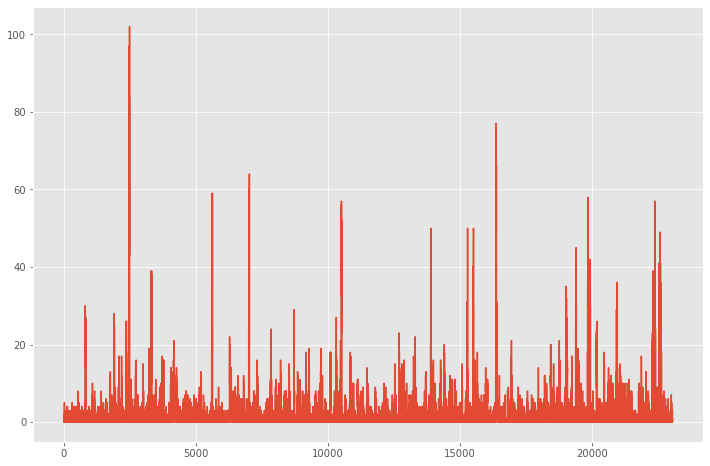

In [6]:
plt.figure(figsize=(12,8))
plt.plot(reduced["sales"])

# Creating a SMALL DATAFRAME frame for testing purposes 


In [88]:
names = np.unique(df['id'])
selected = names[0:1]

small_df = df[df['id'].isin(selected)]
small_df = small_df.sort_values(by = ['id', 'date'])

In [89]:
small_ds = small_df['date']
small_df['MONTH'] = small_ds.dt.month
small_df['DAY_OF_WEEK'] = small_ds.dt.dayofweek
small_df['DAY'] = small_ds.dt.day

small_df

,d,date,weekday,id,sales,MONTH,DAY_OF_WEEK,DAY
0,d_1,2011-01-29,Saturday,FOODS_3_001_TX_3_validation,0,1,5,29
1093,d_2,2011-01-30,Sunday,FOODS_3_001_TX_3_validation,2,1,6,30
1945,d_3,2011-01-31,Monday,FOODS_3_001_TX_3_validation,1,1,0,31
2916,d_4,2011-02-01,Tuesday,FOODS_3_001_TX_3_validation,3,2,1,1
3565,d_5,2011-02-02,Wednesday,FOODS_3_001_TX_3_validation,0,2,2,2
...,...,...,...,...,...,...,...,...
1570915,d_1909,2016-04-20,Wednesday,FOODS_3_001_TX_3_validation,0,4,2,20
1571320,d_1910,2016-04-21,Thursday,FOODS_3_001_TX_3_validation,0,4,3,21
1572292,d_1911,2016-04-22,Friday,FOODS_3_001_TX_3_validation,5,4,4,22
1573265,d_1912,2016-04-23,Saturday,FOODS_3_001_TX_3_validation,2,4,5,23


In [75]:
piv_tab = small_df.pivot_table(index='date',columns='id',values='sales',aggfunc='sum')

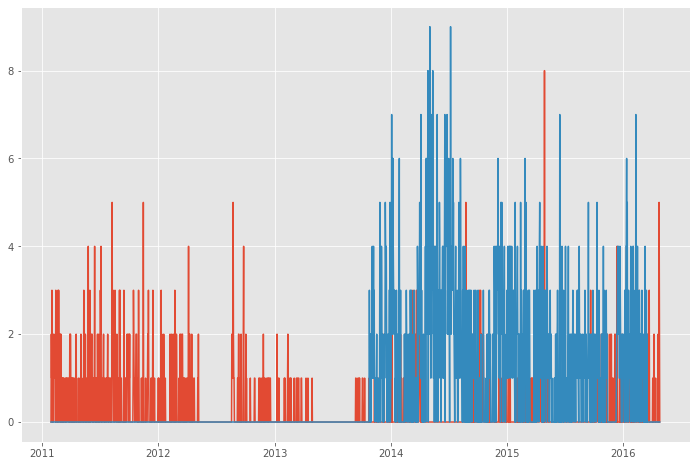

In [76]:
plt.figure(figsize=(12,8))
plt.plot(piv_tab)
plt.show()

# Transition to Poisson Regression

In [20]:
# Getting some additional data for the regression
ds = df['date']
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day


ds1 = df1['date']
df1['MONTH'] = ds.dt.month
df1['DAY_OF_WEEK'] = ds1.dt.dayofweek
df1['DAY'] = ds1.dt.day

ds2 = df2['date']
df2['MONTH'] = ds2.dt.month
df2['DAY_OF_WEEK'] = ds2.dt.dayofweek
df2['DAY'] = ds2.dt.day

In [21]:
df

,d,date,weekday,id,sales,MONTH,DAY_OF_WEEK,DAY
0,d_1,2011-01-29,Saturday,FOODS_3_001_TX_3_validation,0,1,5,29
1093,d_2,2011-01-30,Sunday,FOODS_3_001_TX_3_validation,2,1,6,30
1945,d_3,2011-01-31,Monday,FOODS_3_001_TX_3_validation,1,1,0,31
2916,d_4,2011-02-01,Tuesday,FOODS_3_001_TX_3_validation,3,2,1,1
3565,d_5,2011-02-02,Wednesday,FOODS_3_001_TX_3_validation,0,2,2,2
...,...,...,...,...,...,...,...,...
1570833,d_1909,2016-04-20,Wednesday,FOODS_3_827_TX_3_validation,0,4,2,20
1571482,d_1910,2016-04-21,Thursday,FOODS_3_827_TX_3_validation,1,4,3,21
1572453,d_1911,2016-04-22,Friday,FOODS_3_827_TX_3_validation,0,4,4,22
1573305,d_1912,2016-04-23,Saturday,FOODS_3_827_TX_3_validation,0,4,5,23


# Poisson Regression 

In [77]:
# old way
mask = np.random.rand(len(small_df)) < 0.8
df_train = small_df[mask]
df_test = small_df[~mask]

# New way

#df_train = df
#df_test = df1
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=3032
Testing data set length=794


In [78]:
expr = """sales ~ DAY +  MONTH"""

In [79]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [80]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [81]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  sales   No. Observations:                 3032
Model:                            GLM   Df Residuals:                     3029
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3415.5
Date:                Fri, 10 Dec 2021   Deviance:                       4823.7
Time:                        09:31:24   Pearson chi2:                 7.07e+03
No. Iterations:                     5   Pseudo R-squ. (CS):           0.005969
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3675      0.066     -5.585      0.0

In [82]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

             mean   mean_se  mean_ci_lower  mean_ci_upper
0        0.518666  0.031265       0.460869       0.583712
1945     0.509101  0.032687       0.448902       0.577373
3565     0.654220  0.034803       0.589444       0.726115
6805     0.630312  0.029145       0.575700       0.690104
14462    0.579665  0.022589       0.537039       0.625674
...           ...       ...            ...            ...
1547638  0.527886  0.021561       0.487274       0.571882
1550152  0.513350  0.023704       0.468931       0.561977
1557499  0.618072  0.026291       0.568633       0.671810
1566256  0.557926  0.016347       0.526788       0.590904
1574085  0.513095  0.020020       0.475320       0.553872

[794 rows x 4 columns]


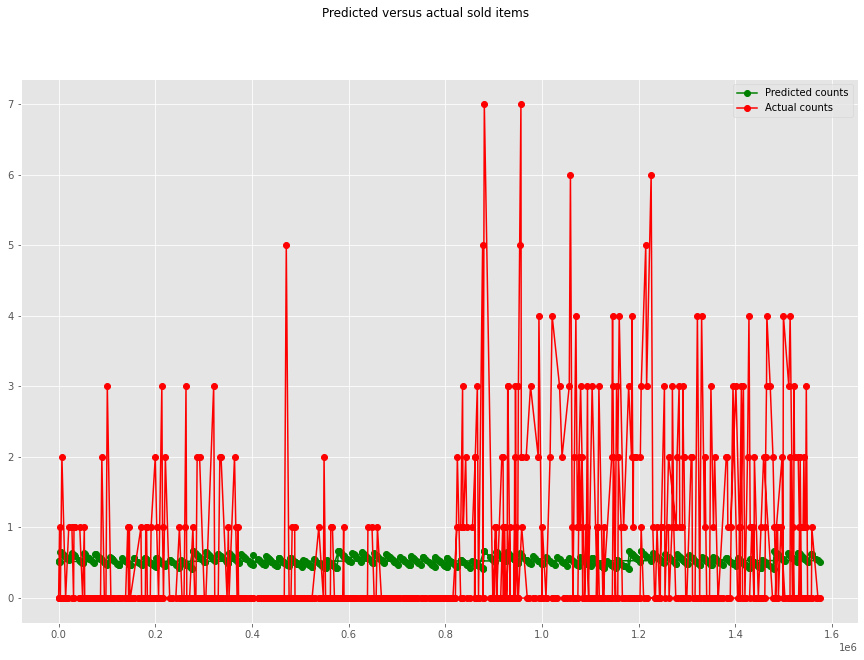

In [83]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['sales']
fig = plt.figure(figsize=(15,10))
fig.suptitle('Predicted versus actual sold items')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()


<Figure size 432x288 with 0 Axes>

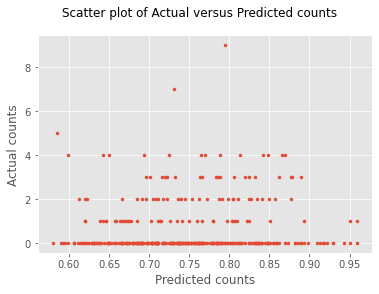

In [71]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

In [72]:
np.mean(y_test['sales'])

0.6328767123287671

# FOR LOOP FOR MULTIVARIATE FORECAST

In [ ]:
names = np.unique(df['id'])

In [ ]:

selected = names[0:1]

small_df = df[df['id'].isin(selected)]
small_df = small_df.sort_values(by = ['id', 'date'])

small_ds = small_df['date']
small_df['MONTH'] = small_ds.dt.month
small_df['DAY_OF_WEEK'] = small_ds.dt.dayofweek
small_df['DAY'] = small_ds.dt.day

small_df

,Intercept,DAY,MONTH
0,1.0,29.0,1.0
1945,1.0,31.0,1.0
3565,1.0,2.0,2.0
6805,1.0,6.0,2.0
14462,1.0,15.0,2.0
...,...,...,...
1547638,1.0,23.0,3.0
1550152,1.0,26.0,3.0
1557499,1.0,4.0,4.0
1566256,1.0,15.0,4.0
